# Analysis of Reddit comment toxicity

### John Burt

[To hide code cells, view this in nbviewer](https://nbviewer.jupyter.org/github/johnmburt/springboard/blob/master/capstone_1/reddit_intersub_analysis_data_story.ipynb) 


### Introduction:

The social media site Reddit is divided into many different communities called subreddits (subs). Each sub covers a specific topic or theme and tends to have regular users posting comments. 

The goal of my first Capstone project is to develop a toxic comment classifier. One of the questions I need to answer is the degree to which the language used in a toxic comment is unique to the sub it is posted in. If toxic comments are mostly the same in every sub, then I can train a single classifier and apply it to every subreddit. If, however the comments in each sub use substantially different language, then I will likely need to train a unique classifier for each subreddit.

In this notebook, I will examine the question of how to detect whether down voted comments are actually toxic (i.e., unwanted and damaging to the conversation), and whether various features extracted from the data are correlated with toxic comments. The features I will examine are:

- Vote score: a low negative vote score probably indicates comment toxicity.



In [3]:
from IPython.display import HTML
# from IPython.display import Image
# Image("eyeexam.jpg")

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

### Methods

The comment data used in this analysis was [acquired using PRAW](https://github.com/johnmburt/springboard/blob/master/capstone_1/reddit_collect_comments_v1.ipynb) from 8 subs. All of these subs are non-political. The political subs are different due to the nature of political discussions and require a different analysis. 

The comment data used here was further processed:
- Only replies to other comments are included here.
- The text, vote scores and PCA score of the comment replied to are included.

In [4]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np
import datetime
import time
import csv
import glob


# source data folder 
srcdir = './data_labeled/'

# data processed to include the comment replied to.
# (comments that are not replies are excluded)
files2use = ['comment_sample_gaming_pics_todayilearned_replies.csv',
             'comment_sample_science_askreddit_photography_replies.csv',
             'comment_sample_videos_replies.csv',
             'comment_sample_aww_funny_replies.csv']

# load all labelled CSVs
dfs = []
for filename in files2use:
    pathname = srcdir+filename
    tdf = pd.read_csv(pathname)
    dfs.append(tdf)

# combine all subreddit datasets into one  
reply_df = pd.concat(dfs).drop_duplicates()

print('\nTotal comment samples read:',reply_df.shape[0])


Total comment samples read: 755032


In [5]:
# drop samples with NaNs
reply_df.dropna(inplace=True)
print('After dropping invalid rows:',reply_df.shape[0])


After dropping invalid rows: 49421


### Count number of "troll reply" words and plot that against the toxicity features

Here I count occurances of "troll reply" words - words that might be used by other users caling out a troll. To begin with, I'll just search for "troll".

# replies found with troll = 519 # without = 48902
mean score no = -14.096233282892316 yes = -16.05009633911368
mean PCA score no = -2.0149453362881173 yes = -2.009232088225381


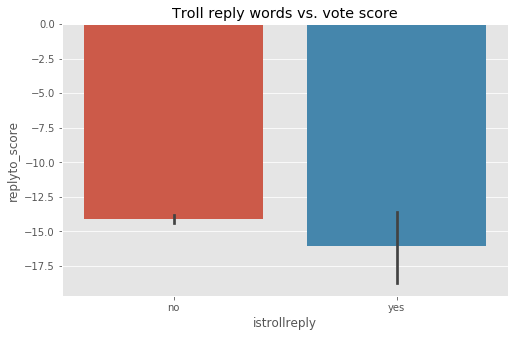

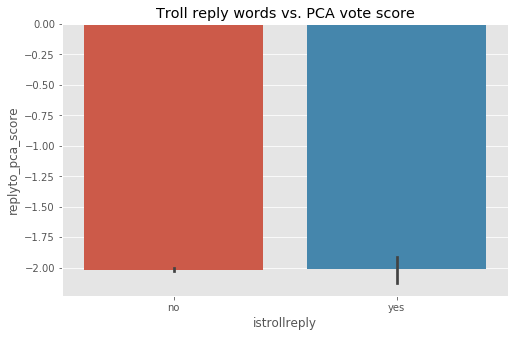

In [6]:
import seaborn as sns

# count occurrances of words associated with accusations of trollery
# trollwords = ['troll','fuck', 'dick', 'jerk', 'asshole']
# trollwords = ['troll','shill','bot']
# trollwords = ['fuck off']
# trollwords = ['troll','fuck off']
trollwords = ['troll']

# create regex expression to search for troll reply words
trolltest = '|'.join(trollwords)

# count replies with at least one of the troll reply words
reply_df['trollcount'] = reply_df.text.str.count(trolltest)

# add boolean column indicating a troll word was in a reply
reply_df['istrollreply'] = np.where((reply_df['trollcount'] > 0),'yes','no')

print('# replies found with',
      trolltest,'=',(reply_df['trollcount'] > 0).sum(),
     '# without =',(reply_df['trollcount'] == 0).sum())

print('mean score no =',
      reply_df[reply_df['trollcount'] == 0].replyto_score.mean(),
      'yes =',
      reply_df[reply_df['trollcount'] > 0].replyto_score.mean(),
     )

print('mean PCA score no =',
      reply_df[reply_df['trollcount'] == 0].replyto_pca_score.mean(),
      'yes =',
      reply_df[reply_df['trollcount'] > 0].replyto_pca_score.mean(),
     )

# sns.lmplot(x='trollcount',y='replyto_score',data=reply_df, fit_reg=True);
# plt.title('Troll reply words vs. vote score');

f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='istrollreply',y='replyto_score',data=reply_df);
plt.title('Troll reply words vs. vote score');

f, ax = plt.subplots(figsize=(8, 5))
# sns.lmplot(x='trollcount',y='replyto_pca_score',data=reply_df, fit_reg=True);
# plt.title('Troll reply words vs. normalized PCA score (combines # replies and vote score)');
sns.barplot(x='istrollreply',y='replyto_pca_score',data=reply_df);
plt.title('Troll reply words vs. PCA vote score');


### Same analysis, but looking at the ratio between scores for possible troll and replies to them.

mean score ratio no = -1.926250917337358 yes = -3.638820653724519
mean PCA score ratio no = 1.0003762292138494 yes = 0.8305137223674663


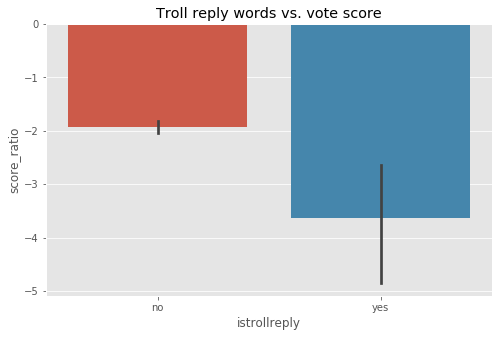

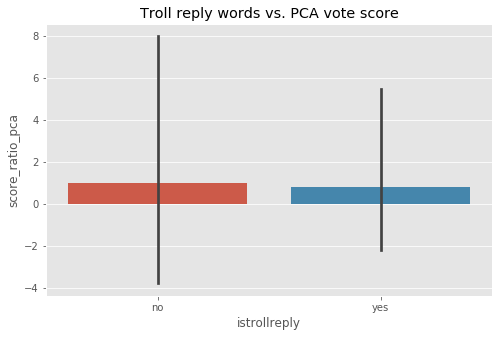

In [7]:

reply_df['score'][reply_df['score']==0] = -1
reply_df['score_ratio'] = reply_df['replyto_score']/reply_df['score']
reply_df['score_ratio_pca'] = reply_df['replyto_pca_score']/reply_df['pca_score']

print('mean score ratio no =',
      reply_df[reply_df['trollcount'] == 0].score_ratio.mean(),
      'yes =',
      reply_df[reply_df['trollcount'] > 0].score_ratio.mean(),
     )

print('mean PCA score ratio no =',
      reply_df[reply_df['trollcount'] == 0].score_ratio_pca.mean(),
      'yes =',
      reply_df[reply_df['trollcount'] > 0].score_ratio_pca.mean(),
     )

f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='istrollreply',y='score_ratio',data=reply_df);
plt.title('Troll reply words vs. vote score');

f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='istrollreply',y='score_ratio_pca',data=reply_df);
plt.title('Troll reply words vs. PCA vote score');

